In [2]:
!pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 1.3/102.4 MB 7.7 MB/s eta 0:00:14
    --------------------------------------- 2.4/102.4 MB 7.2 MB/s eta 0:00:14
   - -------------------------------------- 3.9/102.4 MB 6.6 MB/s eta 0:00:15
   -- ------------------------------------- 5.2/102.4 MB 6.6 MB/s eta 0:00:15
   -- ------------------------------------- 6.3/102.4 MB 6.3 MB/s eta 0:00:16
   --- ------------------------------------ 7.9/102.4 MB 6.5 MB/s eta 0:00:15
   --- ------------------------------------ 9.4/102.4 MB 6.6 MB/s eta 0:00:15
   --- ------------------------------------ 10.2/102.4 MB 6.6 MB/s eta 0:00:14
   ---- ----------------------------------- 11.5/102.4 MB 6.2 MB/s eta 0:00:15
   ----- ---------------------------------- 12.8/102.4 MB 6.3 MB/s eta 0:00:15
   ----- ---------------------------------- 13.6/102.4 MB 6.2 MB/s eta 0:00:15
   ----- ---------------------------------- 14.4/102.4 MB 5.8 MB/s 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [4]:
df=pd.read_csv("data/stud.csv")

In [5]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Preparing X and Y variables

In [6]:
x=df.drop(columns='math_score',axis=1)

In [7]:
x.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [10]:
print("categories in gender :",end="")
print(df['gender'].unique())
print("categories in race ethnicity :",end="")
print(df['race_ethnicity'].unique())
print("categories in parental level of education  :",end="")
print(df['parental_level_of_education'].unique())
print("categories in lunch :",end="")
print(df['lunch'].unique())
print("categories in test preparation course :",end="")
print(df['test_preparation_course'].unique())

categories in gender :['female' 'male']
categories in race ethnicity :['group B' 'group C' 'group A' 'group D' 'group E']
categories in parental level of education  :["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
categories in lunch :['standard' 'free/reduced']
categories in test preparation course :['none' 'completed']


In [11]:
y=df['math_score']

In [12]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

In [17]:
# Create Column Transformer with 3 types of transformers
num_features=x.select_dtypes(exclude="object").columns
cat_features=x.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer=StandardScaler()
oh_transformer=OneHotEncoder()

preprocessor=ColumnTransformer([("OneHotEncoder",oh_transformer,cat_features),
                                ("StandardScaler",numeric_transformer,num_features),])

In [18]:
x=preprocessor.fit_transform(x)

In [19]:
x.shape

(1000, 19)

In [20]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=12)
xtrain.shape,xtest.shape

((800, 19), (200, 19))

Create an Evaluate Function to give all metrics after model Training

In [22]:
def evaluate_model(true,predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    rmse=np.sqrt(mean_squared_error(true,predicted))
    r2=r2_score(true,predicted)
    return mae,rmse,r2

In [24]:
models={
    "LinearRegression":LinearRegression(),
    "Lasso":Lasso(),
    "Ridge":Ridge(),
    "K-Neighbours Regressor":KNeighborsRegressor(),
    "DecisionTree":DecisionTreeRegressor(),
    "RandomForest Regressor":RandomForestRegressor(),
    "XGBRegressor":XGBRegressor(),
    "CatBoosting Regressor":CatBoostRegressor(verbose=False),
    "Adaboost Regressor":AdaBoostRegressor()
}
model_list=[]
r2_list=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(xtrain,ytrain)  #train model

    #make predicitons
    ytrain_pred=model.predict(xtrain)
    ytest_pred=model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae,model_train_rmse,model_train_r2=evaluate_model(ytrain,ytrain_pred)
    model_test_mae,model_test_rmse,model_test_r2=evaluate_model(ytest,ytest_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("-Root mean squared error: {:.4f}".format(model_test_rmse))
    print("-Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("-R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

    r2_list.append(model_test_r2)

    print('='*35)
    print("\n")

LinearRegression
Model performance for Training set
-Root mean squared error: 4.7574
-Mean Absolute Error: 4.3826
-R2 Score: 0.8736
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4.7574
- Mean Absolute Error: 3.7267
- R2 Score: 0.8889


Lasso
Model performance for Training set
-Root mean squared error: 6.1737
-Mean Absolute Error: 5.2788
-R2 Score: 0.8132
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.1737
- Mean Absolute Error: 4.7672
- R2 Score: 0.8129


Ridge
Model performance for Training set
-Root mean squared error: 4.7565
-Mean Absolute Error: 4.3819
-R2 Score: 0.8736
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4.7565
- Mean Absolute Error: 3.7233
- R2 Score: 0.8889


K-Neighbours Regressor
Model performance for Training set
-Root mean squared error: 6.1407
-Mean Absolute Error: 4.7690
-R2 Score: 0.8484
----------------------------------


Results

In [25]:
pd.DataFrame(list(zip(model_list,r2_list)),columns=['Model Name','R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.888915
0,LinearRegression,0.888871
7,CatBoosting Regressor,0.850853
8,Adaboost Regressor,0.842029
5,RandomForest Regressor,0.838929
3,K-Neighbours Regressor,0.814852
1,Lasso,0.812857
6,XGBRegressor,0.801193
4,DecisionTree,0.648785


Linear Regression

In [27]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(xtrain, ytrain)
y_pred = lin_model.predict(xtest)
score = r2_score(ytest, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.89


Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

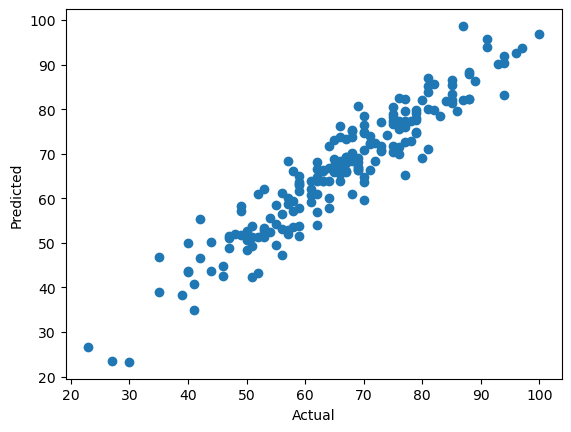

In [29]:
plt.scatter(ytest,y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

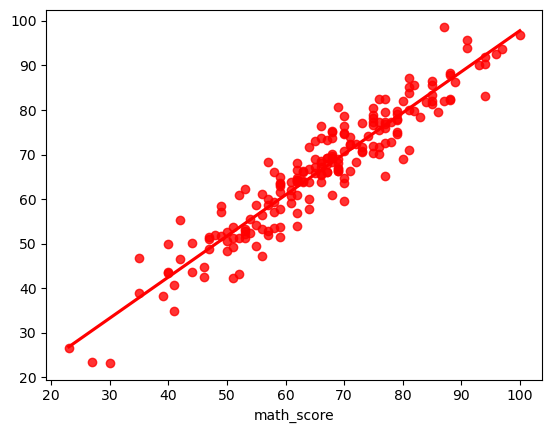

In [31]:
sns.regplot(x=ytest,y=y_pred,ci=None,color ='red');

Difference between Actual and Predicted Values

In [33]:
pred_df=pd.DataFrame({'Actual Value':ytest,'Predicted Value':y_pred,'Difference':ytest-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
518,66,67.268057,-1.268057
871,70,64.691260,5.308740
797,70,76.359154,-6.359154
274,88,82.275325,5.724675
325,82,85.610024,-3.610024
...,...,...,...
909,70,74.931894,-4.931894
757,70,74.561038,-4.561038
965,62,64.249719,-2.249719
4,76,82.518131,-6.518131
